# Bias Correction using GloFAS Forecast Data

The Global Flood Awareness System (GloFAS) creates a hydrograph for grid locations and compares it to historical data. With this information, GloFAS then calculates the daily flood forecasts for each grid location. By using Routing Application for Parallel computation of Discharge (RAPID), the grid is divided into watersheds.

The European Centre for Medium-Range Weather Forecasts (ECMWF) produces a 51-member gridded ensemble runoff forecast file every 12 hours. They also produce a 35-year runoff re-analysis (1980-2014) file which allows them to give context to their forecasts (i.e. return periods and exceedance probabilities).

CEMS-Floods (EFAS and GloFAS) datasets are openly available on the Copernicus Climate Change Service (C3S) Climate Data Store (CDS). The CDS provides access through web-based and API-based search and retrieve facilities. It is an easy way for users to access climate-related data, including CEMS-Flood data.  Access to the Climate Data Store is available via the web at [Copernicus Climate Data Store](https://cds.climate.copernicus.eu/#!/home) . 

https://confluence.ecmwf.int/display/COPSRV/Data+services

### Import modules

In [363]:
# Find the directory of the current project and add to PATH
import sys, os, arcpy
home_folder = arcpy.mp.ArcGISProject("current").homeFolder
sys.path.insert(0, home_folder)
os.chdir(home_folder)

# The 00_environment_setup notebook contains libraries and other things common to all the notebooks (e.g. file paths)
%run "00_environment_setup.ipynb"

Active Portal in ArcGIS Pro
Logged in as ksampson
Current conda environment:
	arcgispro-py3-clone C:\Users\ksampson\AppData\Local\ESRI\conda\envs\arcgispro-py3-clone
Found input data directory: C:\Users\ksampson\Documents\GitHub\GloFAS_Q2Q_Bias_Correction_and_Verification\data\input
Completed importing and/or installing libraries in 4.57 seconds.


### Define locations of data we wish to use

The Research Applications Laboratory at the National Center for Atmospheric Research has previously identified a number of forecast locations where observations may be compared against GloFAS forecast data. The station metadata is located in a CSV file titled `glofas_station_details.CSV` and an archive of forecasts and observations has been created titled `Archive.zip`. These files may be accessed remotely using python libraries such as `requests`, which can access information given a URL, and `ZipFile` (to access the .zip archive)

In [364]:
# Location of bias correction support data
archive_ZIP = 'https://staff.ral.ucar.edu/hopson/GloFAS/Q2Qbiascorrection/Lookup_data/Archive.zip'
station_details_URL = 'https://staff.ral.ucar.edu/hopson/GloFAS/Q2Qbiascorrection/glofas_stations_details.CSV'

### Open the supporting files and identify available station locations

In the cell below, we will obtain the .zip information and store it in an in-memory object using `BytesIO`. We will also store a list of files within the .zip archive and create a list of available station IDs from the filenames within that archive.

In [365]:
%%time

# Open archive zip file on web, and convert CSV to pandas DataFrame
if archive_ZIP.startswith('http'):
    content = requests.get(archive_ZIP)
    archive_ZIP = BytesIO(content.content)
    
# Unzip the file and read the contents
f = ZipFile(archive_ZIP)
filelist = f.namelist()

# Get lists of station names
stations_list = list(set([item.rsplit('_')[0] for item in filelist if item.endswith('.CSV')]))
print('Found {0} unique station IDs.'.format(len(stations_list)))

Found 66 unique station IDs.
Wall time: 857 ms


### Select a station using a drop-down widget

Here, we will use a Jupyte ipython Widget, which is a drop-down selection box. If we provide the `drop_down_select` function with a list and a descriptor, Jupyter will render the list and populate the widget object class `w` with our selection.

In [366]:
# Station selection dropdown
w = drop_down_select(stations_list, descriptor='Station:')
print('Select a station')
display(w)

Select a station


Dropdown(description='Station:', options=('022-mgd4ptn', '001NEID3', '011-mgd4ptn', '001-MGD5PTN', '009-MGD1LK…

In [367]:
station_name = w.value
print('Station Selected: {0}'.format(station_name))

Station Selected: 022-mgd4ptn


### Plot the selected station

Take the selection from above, and create a map widget using the station metadata information (ID, location) from the station details data frame.

In [368]:
# Create a data frame
df = pd.read_csv(station_details_URL)
df = df.loc[df['sta_id']==w.value]

# Create a spatially enabled data frame
sedf = pd.DataFrame.spatial.from_xy(df=df, x_column='lon_cwc', y_column='lat_cwc', sr=4326)

# Passing a place name to the constructor will initialize the extent of the map.
m1 = gis.map('India', zoomlevel=10)

# Change the size of the map widget
m1.layout = Layout(flex='1 1', padding='0px', height='600px')

# Plot the SEDF on the map
sedf.spatial.plot(map_widget=m1)

# Specify map center point. Must reverse coordinate order here
m1.center = [sedf.iloc[0].lat_cwc, sedf.iloc[0].lon_cwc]

# Set a basemap (optional)
#m1.basemap = "satellite"

# Diaplay the map widget
m1

MapView(layout=Layout(flex='1 1', height='600px', padding='0px'))

### Read the forecast and observation time series at the selected station

Get a list of files in the archive .zip file that start with this staion ID.

In [369]:
# Get list of files for selected station
station_file_list = [item for item in filelist if item.startswith(station_name)]
print('Found {0} files for station ID "{1}"".'.format(len(station_file_list), station_name))

Found 17 files for station ID "022-mgd4ptn"".


For each location, NCAR has archived the forecast data by forecast lead time (in days). The following code block will read each file in the archive .zip file and determine the lead-time in days using the file name.

In [370]:
# Generate list of available lead times for this station
leadtime_list = [item.split('_f')[1].split('.CSV')[0] for item in station_file_list if '_f' in item]
print('Found {0} forecast lead-time files for station ID "{1}".'.format(len(leadtime_list), station_name))

Found 16 forecast lead-time files for station ID "022-mgd4ptn".


Now, use the `drop_down_select` function to create a selection widget to select the desired forecast lead time to examine.

In [371]:
# Forecast lead-time selection dropdown
x = drop_down_select(leadtime_list, descriptor='Lead Time:')
print('Choose a lead time')
display(x)

Choose a lead time


Dropdown(description='Lead Time:', options=('1d', '2d', '3d', '4d', '5d', '6d', '7d', '8d', '9d', '10d', '11d'…

In [372]:
# Set lead time from user-selected value (drop down)
lead_time = x.value
print('Lead time selected for station "{0}": {1}'.format(station_name, lead_time))

Lead time selected for station "022-mgd4ptn": 1d


Next, we will find the observed river stage information for the selected forecast location. This file has a file name that ends with `_obs.CSV`. Then, find the forecasted river flow information for the forecast lead time selected above. 

In [373]:
# Identify the observation file
obscsvfile = '{0}_obs.CSV'.format(station_name)
assert obscsvfile in station_file_list

# Identify the forecast lead time file
modcsvfile =  '{0}_f{1}.CSV'.format(station_name, lead_time)
assert modcsvfile in station_file_list

print('Station name: {0}'.format(station_name))
print('Modeled flow value file: {0}'.format(filelist[filelist.index(obscsvfile)]))
print('Observed flow value file: {0}'.format(filelist[filelist.index(modcsvfile)]))

Station name: 022-mgd4ptn
Modeled flow value file: 022-mgd4ptn_obs.CSV
Observed flow value file: 022-mgd4ptn_f1d.CSV


Open the observation and forecast files for the desired station and forecast lead time, reading each into a pandas DataFrame. Print the number of records in each file.

In [374]:
# Read the observation time series
g = f.open(filelist[filelist.index(obscsvfile)], 'r')
obsclim_df = pd.read_csv(g, header=None, names=['obs'])
print('There are {0} values in the observation file for lead time {1} at station {2}.'.format(len(obsclim_df), lead_time, station_name))

# Read the forecast time series for the selected lead time
g = f.open(filelist[filelist.index(modcsvfile)], 'r')
modclim_df = pd.read_csv(g, header=None, names=['model'])
print('There are {0} values in the simulation file for lead time {1} at station {2}.'.format(len(modclim_df), lead_time, station_name))

There are 2859 values in the observation file for lead time 1d at station 022-mgd4ptn.
There are 12645 values in the simulation file for lead time 1d at station 022-mgd4ptn.


### Plot the data

In this section, we will plot the raw, pre-sorted values for the observed (stage) data and the corresponding simulated (flow rate) values for the same location.

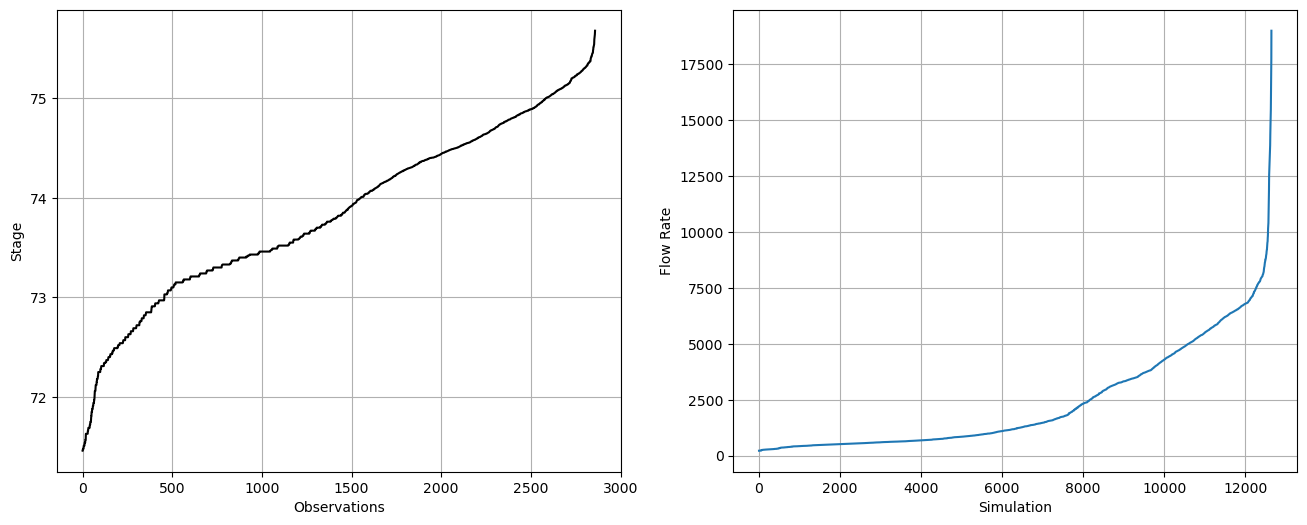

In [375]:
%matplotlib inline

# Setup plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

# Observed value distribution
axes[0] = obsclim_df['obs'].plot(ax=axes[0], label=station_name, color='black', grid=True)
axes[0].set_xlabel("Observations")
axes[0].set_ylabel("Stage")

# Forecast value distribution
axes[1] = modclim_df['model'].plot(ax=axes[1], label=station_name, color='#1f77b4', grid=True)
axes[1].set_xlabel("Simulation")
axes[1].set_ylabel("Flow Rate")

# Display plot
plt.show()

### Plot the freqency distribution of the data

First, print the descriptive statistics for the observed stage and simulated flow values from each of the data sources for this location, using the `.describe()` function of the pandas DataFrame object.

In [376]:
# Descriptive statistics of each data series
print('Observed flow statistics:')
display(obsclim_df['obs'].describe())
print('Simulated flow statistics:')
display(modclim_df['model'].describe())

Observed flow statistics:


count    2859.000000
mean       73.853613
std         0.867295
min        71.460000
25%        73.270000
50%        73.820000
75%        74.547750
max        75.677800
Name: obs, dtype: float64

Simulated flow statistics:


count    12645.000000
mean      2362.384529
std       2356.240534
min        220.141000
25%        611.590000
50%       1205.250000
75%       3694.520000
max      19003.500000
Name: model, dtype: float64

In the following code block, we will use a pre-created function `get_cdf` to calculate the Cumulative Distribution Function (CDF) for each dataset. Next, we will plot each CDF next to each other for comparison.

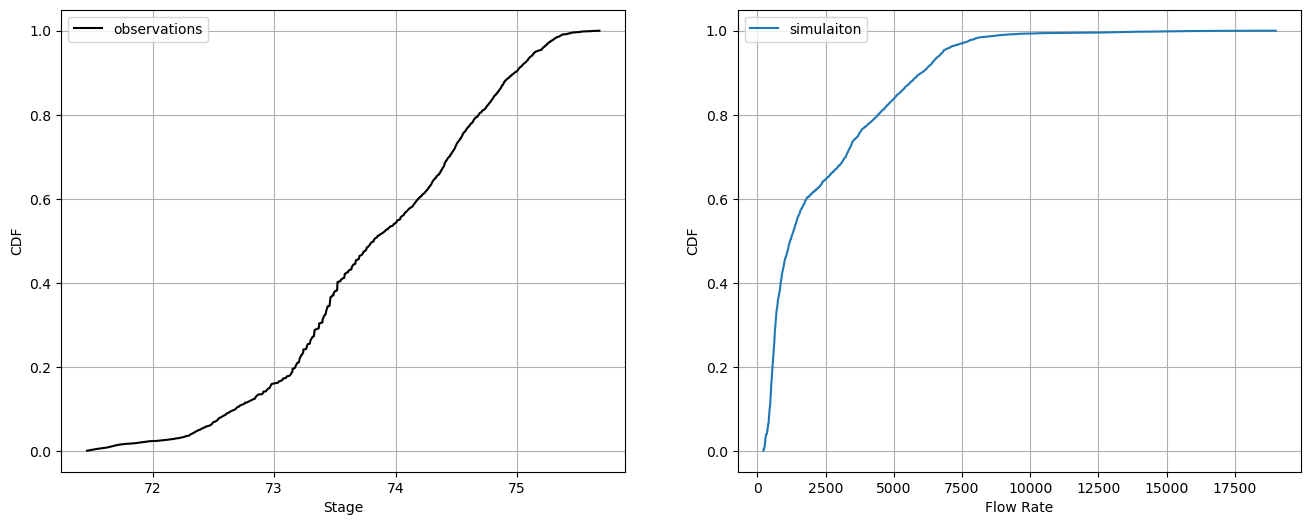

In [377]:
%matplotlib inline

# Calculate and add the CDF to the DataFrames
obsclim_df = get_cdf(obsclim_df, column='obs')
modclim_df = get_cdf(modclim_df, column='model')

# Setup plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

# Plot the observed data series cumulative density funciton (CDF)
axes[0] = obsclim_df.plot(ax=axes[0], x='obs', y=['cdf'], label=['observations'], color='black', grid=True)
axes[0].set_xlabel("Stage")
axes[0].set_ylabel("CDF")

# Plot the simulated data series cumulative density funciton (CDF)
axes[1] = modclim_df.plot(ax=axes[1], x='model', y=['cdf'], label=['simulaiton'], color='#1f77b4', grid=True)
axes[1].set_xlabel("Flow Rate")
axes[1].set_ylabel("CDF")

# Display plot
plt.show()

### Ilustrate the bias correction process using plots

To illustrate the Q2Q bias correction process, we will take the cumulative distribution function (CDF) of the observed (stage) and simulated (flow rate) and then find the percentile of the predicted flow and map that onto the CDF from the observations to find a bias-corrected stage value.

The cell below builds identical plots to those above, but annotates them with arrows that illustrate the Q2Q process, moving from simulation value to percentile, then to observed percentile and finally bias-corrected observation value.

In [378]:
# Choose the value to plot for illustrative purposes (Median of the modeled values)
sim_val = modclim_df['model'].median()
    
# Use the NCAR Q2Q method, which is located in the 00_environment_setup.ipynb notebook
q2q_corrected, pct_frac = q2q(modclim_df['model'], 
                              obsclim_df['obs'], 
                              sim_val, 
                              return_pct=True)
print('Plotting quantile mapping for forecast value {0} to stage value {1:3.2f}'.format(sim_val, q2q_corrected[0]))

Plotting quantile mapping for forecast value 1205.25 to stage value 73.82


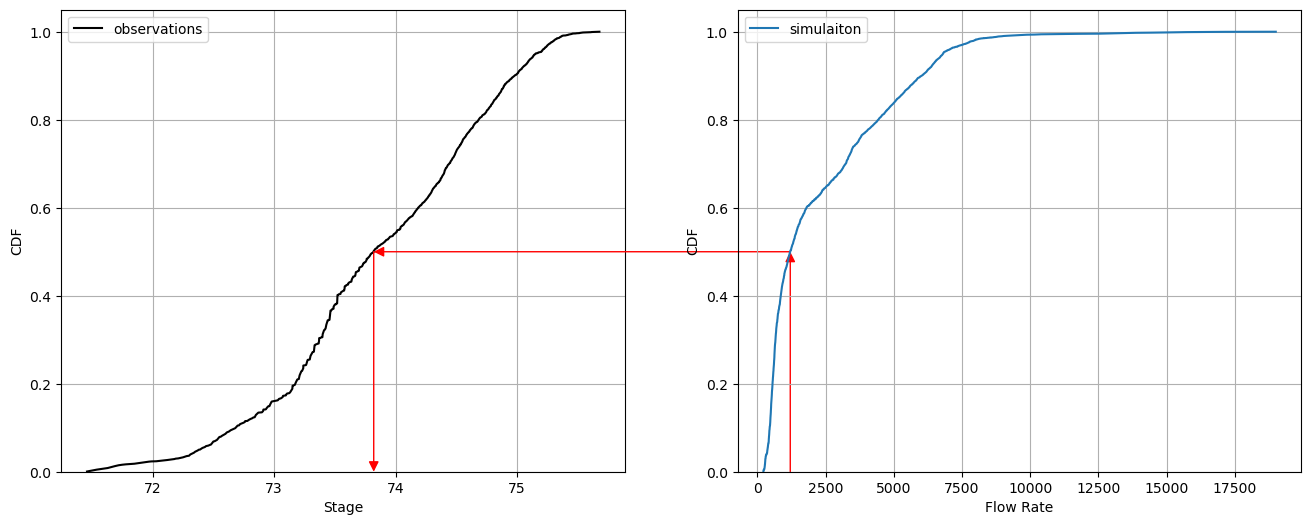

In [379]:
%matplotlib inline

# Setup plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

# Plot the observed data series cumulative density funciton (CDF)
axes[0] = obsclim_df.plot(ax=axes[0], x='obs', y=['cdf'], label=['observations'], color='black', grid=True)
axes[0].set_xlabel("Stage")
axes[0].set_ylabel("CDF")
axes[0].set_ylim(0,1.05)

# Plot the simulated data series cumulative density funciton (CDF)
axes[1] = modclim_df.plot(ax=axes[1], x='model', y=['cdf'], label=['simulaiton'], color='#1f77b4', grid=True)
axes[1].set_xlabel("Flow Rate")
axes[1].set_ylabel("CDF")
axes[1].set_ylim(0,1.05)

# Draw the connection between the two plots to illustrate the bias correction
from matplotlib.patches import ConnectionPatch
con1 = ConnectionPatch(xyA=(q2q_corrected, pct_frac), xyB=(sim_val, pct_frac), coordsA="data", coordsB="data", axesA=axes[0], axesB=axes[1], color="red", arrowstyle="<|-", mutation_scale=15, fc="red")
con2 = ConnectionPatch(xyA=(sim_val, pct_frac), xyB=(sim_val,0.0), coordsA="data", coordsB="data", axesA=axes[1], axesB=axes[1], color="red", arrowstyle="<|-", mutation_scale=15, fc="red")
con3 = ConnectionPatch(xyA=(q2q_corrected,0.0), xyB=(q2q_corrected, pct_frac), coordsA="data", coordsB="data", axesA=axes[0], axesB=axes[0], color="red", arrowstyle="<|-", mutation_scale=15, fc="red")
axes[1].add_artist(con1)
axes[1].add_artist(con2)
axes[1].add_artist(con3)

# Display plot
plt.show()

### Perform bias-correction

The user will specify a list or numpy array of values which will be bias corrected for the selected station. Using the `scipy.stats.percentileofscore` function to obtain the percentile of the specified values within the distribution of simulation values, the next step is to bias correct. This process will use the `scipy.stats.scoreatpercentile` function to find the value within the observation data that corresponds to the percentile within the simulation data.

In [380]:
# Hypothetical forecast values
forecast_values = np.array([0., 20., 90., 100., 5000., 25000.])

# Bias correction using an array of forecast values
q2q_corrected = q2q(modclim_df['model'], obsclim_df['obs'], forecast_values)

# Return message to user
print('The forecasted values (flow rate) are:  {0}'.format(forecast_values))
#print('The percentiles of forecasted flow are: {0}'.format(fcst_percentiles))
print('The bias-corrected stage values are:    {0}'.format(q2q_corrected.tolist()))

The forecasted values (flow rate) are:  [0.0e+00 2.0e+01 9.0e+01 1.0e+02 5.0e+03 2.5e+04]
The bias-corrected stage values are:    [71.46, 71.46, 71.46, 71.46, 74.79975136417556, 75.6778]


### Notes on bias correction

Here, we have taken a database of observations and simulations for a given station and lead-time, and used a simple bias-correction teqnique (quantile-mapping) to convert a simulated value to an observation. If we are given a streamflow forecast that uses the same model that is represented by our simulation database, we can use the same method to bias-correct the forecast.

### Save the map document before moving on to the next module

In [381]:
aprx.save()

### Reset the namespace

The following `%reset -f` command is a built-in command in Jupyter Notebook that will reset the namespace. This is good practice to run when you are finished with the notebook.

In [382]:
%reset -f

# Next up - GEOGloWS Streamflow Forecast Data and API
This concludes Lesson **N4_Plot_and_Bias_Correct_Time_Series.ipynb**. In the next lesson, we will learn about the GEOGloWS global forecast data and python API.

**IT IS BEST TO EITHER SHUTDOWN THIS LESSON OR CLOSE IT BEFORE PROCEEDING TO THE NEXT LESSON TO AVOID POSSIBLY EXCEEDING ALLOCATED MEMORY. Select `Command Pallette -> restart kernel`.**

© UCAR 2023